In [2]:
!pip install surprise
!pip install sentence-transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Recommender system for books: Modelisation

In [4]:
# Data manipulation
import pandas as pd 
import numpy as np 
import gc

# Graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modelisation libraries
from surprise import BaselineOnly, SVD, NMF, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import Dataset
from surprise import Reader

from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
path = '/content/drive/My Drive/Ingénieur ML - OC/P7/Datasets/'

In [ ]:
# Importing data about users and books 
users = pd.read_parquet(path+"users_data_cleaning.parquet.gzip")
books = pd.read_parquet(path+"books_data_cleaning.parquet.gzip")

It exists different kinds of recommender engines. In this proof of concept, simple recommender, user based collaborative filtering, content-based recommender and hybrid methods will be testing to find the best recommender engines. 

## 1) Simple recommender

Simple recommender is the most basic recommender engines. It based on popularity. To calcule it, rating and number of reviews are used. The formula used in the following is the formula used by the IMDB website to calcule.  

*Source:* https://www.datacamp.com/community/tutorials/recommender-systems-python

In [ ]:
# creating a new dataset for the calculus
simple_reco = books.copy()
simple_reco = simple_reco[["Id", "Name", "Authors",
                           "Rating", "CountsOfReview"]]
simple_reco.head()

,Id,Name,Authors,Rating,CountsOfReview
0,4000063,The Flintstones in Viva Rock Vegas,Ellen Miles,3.82,1
1,4000100,Little Rhody,Neta Lohnes Frazier,4.33,1
2,4000228,Finance And Investments Using The Wall Street ...,Peter R. Crabb,0.00,0
3,4000366,Shorty McCabe Looks 'Em Over,Sewell Ford,0.00,0
4,4000441,Plant Pathology,George N. Agrios,4.52,0


In [ ]:
# calculating the average rating
C = simple_reco['Rating'].mean()
print(C)

3.7320950652695215


In [ ]:
# calculating and keeping
# books with the 90th percentile
m = simple_reco['CountsOfReview'].quantile(0.90)
print(m)

41.0


In [ ]:
# selecting only books with at least 41 reviews
q_books = simple_reco.copy().loc[simple_reco['CountsOfReview'] >= m]
q_books.shape

(12116, 5)

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['CountsOfReview']
    R = x['Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
q_books['score'] = q_books.apply(weighted_rating, axis=1)

In [ ]:
#Sort movies based on score calculated above
q_books = q_books.sort_values('score', ascending=False)

#Print the top 15 books
q_books[["Id",'Name', "Authors", 'CountsOfReview', 'Rating', 'score']].head(20)

,Id,Name,Authors,CountsOfReview,Rating,score
44289,862041,"Harry Potter Series Box Set (Harry Potter, #1-7)",J.K. Rowling,6522,4.74,4.733703
40413,818056,Harry Potter and the Deathly Hallows (Harry Po...,J.K. Rowling,952,4.62,4.583339
115327,1215032,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,16523,4.57,4.567926
61446,3165162,Percy Jackson and the Olympians (Percy Jackson...,Rick Riordan,546,4.59,4.530078
72565,1025685,"The Absolute Sandman, Volume Two",Neil Gaiman,198,4.69,4.525673
91715,2495562,The Wise Man's Fear (The Kingkiller Chronicle...,Patrick Rothfuss,488,4.56,4.495833
82953,2186848,"The Absolute Sandman, Volume Three",Neil Gaiman,140,4.71,4.488486
98149,2767793,"The Hero of Ages (Mistborn, #3)",Brandon Sanderson,10101,4.49,4.486936
30441,1179967,"A Storm of Swords (A Song of Ice and Fire, #3)",George R.R. Martin,583,4.54,4.486917
66035,3362870,"The Hero of Ages (Mistborn, #3)",Brandon Sanderson,1289,4.49,4.466636


In [ ]:
print(np.sqrt(mean_squared_error(q_books['Rating'],
                                 q_books["score"])))

0.10848119654754877


In [ ]:
del q_books, simple_reco
gc.collect()

0

## 2) User-based collaborative filtering

### a) Preparing the data for Surprise library

In [ ]:
reader = Reader(rating_scale=(1, 5))
data_surprise = Dataset.load_from_df(users[['User_Id', 'Id', 'Rating']], reader)

In [ ]:
trainset, testset = train_test_split(data_surprise, test_size=.2)

In [ ]:
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
base_als = BaselineOnly(bsl_options=bsl_options)
predictions = base_als.fit(trainset).test(testset)

Estimating biases using als...


In [ ]:
del predictions
gc.collect()

0

In [ ]:
bsl_options = {'method': 'sgd',
               'learning_rate': .00005,
               }
base_sgd = BaselineOnly(bsl_options=bsl_options)
predictions = base_sgd.fit(trainset).test(testset)

Estimating biases using sgd...


In [ ]:
del predictions
gc.collect()

0

### b) Matrix Factorization based algorithms

In [ ]:
svd = SVD()
nmf = NMF()

In [ ]:
model = [svd, nmf]
dict_model = {}

for model in model:
    y_pred = model.fit(trainset).test(testset)
    rmse = accuracy.rmse(y_pred)
    dict_model[model] = rmse.round(3)

print(dict_model)

RMSE: 0.7643
RMSE: 0.8703
{<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fdde012b5b0>: 0.764, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fdde012b910>: 0.87}


In [ ]:
param_grid = {'n_factors': [50, 75, 100, 125],
              'n_epochs': [5, 10, 15, 20, 25], 
              'lr_all': [0.001, 0.002, 0.005, 0.1],
              'reg_all': [0.1, 0.2, 0.4, 0.6],
              'random_state' : [42]
}

gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=5)

gs.fit(data_surprise)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.7496259504461186
{'n_factors': 125, 'n_epochs': 25, 'lr_all': 0.1, 'reg_all': 0.1, 'random_state': 42}


In [ ]:
svd_gs = gs.best_estimator['rmse']
predictions = svd_gs.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.7515


0.7514988478795563

In [ ]:
del predictions, gs, dict_model
gc.collect()

0

### c) K-NN based models

In [ ]:
# Initializing similarities options
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between users
               }

In [ ]:
knnbasic = KNNBasic()
knnmeans = KNNWithMeans()
knnzscore = KNNWithZScore()

In [ ]:
model = [knnbasic, knnmeans, knnzscore]
dict_model = {}

for model in model:
    y_pred = model.fit(trainset).test(testset)
    rmse = accuracy.rmse(y_pred)
    dict_model[model] = rmse.round(3)

print(dict_model)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7693
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7678
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7617
{<surprise.prediction_algorithms.knns.KNNBasic object at 0x7fdd3e9c5220>: 0.769, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fdd3e9c5250>: 0.768, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7fdd3e9c5c10>: 0.762}


In [ ]:
param_grid = {'k': [20, 30, 40, 50, 60, 70, 80]}

gs = GridSearchCV(KNNWithZScore,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=5)

gs.fit(data_surprise)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [ ]:
knn_gs = gs.best_estimator['rmse']
predictions = knn_gs.fit(trainset).test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.7438


0.7438439694579394

In [ ]:
del gs,\
    dict_model,\
    predictions
gc.collect()

0

## 3) Content-based algorithms

### a) With Tfidf

https://medium.com/analytics-vidhya/content-based-recommender-systems-in-python-2b330e01eb80

In [ ]:
desc = books.copy()
desc = desc[["Id", "Name", "Authors", "Description"]]

In [ ]:
desc = desc.sample(frac=.35,
                   random_state=42)

In [ ]:
desc.reset_index(inplace=True)
desc.drop("index", axis=1, inplace=True)

In [ ]:
tfidf = TfidfVectorizer(stop_words='english')
desc['Description'] = desc['Description'].fillna("")

descr_matrix = tfidf.fit_transform(desc['Description'])
descr_matrix.shape

(23916, 82723)

In [ ]:
similarity_matrix = linear_kernel(descr_matrix, descr_matrix)

In [ ]:
mapping = pd.Series(desc.index,
          index = desc['Name'])
print(mapping)

Name
On the Other Side of Mount Ararat: A Story of a Vanished City        0
The Tall Uncut: Stories                                              1
Heart Essence of the Vast Expanse: A Story of Transmission           2
Don't Look a Ghost Horse in the Mouth                                3
Turpentine                                                           4
                                                                 ...  
Infernal Revenue (The Destroyer, #96)                            23911
Die with Me                                                      23912
Kingyo: The Artistry of the Japanese Goldfish                    23913
The Shadow Roads (The Swans' War, book 3)                        23914
Roommates                                                        23915
Length: 23916, dtype: int64


In [ ]:
def recommend_books(book_input):
    book_index = mapping[book_input]
    #get similarity values with other books
    #similarity_score is the list of index and similarity matrix
    similarity_score = list(enumerate(similarity_matrix[book_index]))
    #sort in descending order the similarity score of movie inputted with all the other books
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 20 most similar books. Ignore the first book.
    similarity_score = similarity_score[1:20]
    
    #return book names using the mapping series
    book_indices = [i[0] for i in similarity_score]
    return (desc['Name'].iloc[book_indices])

In [ ]:
recommend_books('It')

3230                                  Black Cat, Volume 11
15651    Glimpses of Maine's Angling Past (Images of Am...
18878                        Oh, the Thinks You Can Think!
14474                           Go to the Room of the Eyes
663      Boston and the American Revolution: Boston Nat...
9972                                                   Ash
10932               True Blue (Sweet Valley Jr. High, #18)
18362                                            Bold Wolf
8047     African American Life in the Rural South, 1900...
7174                                       White House Q&A
17721                                        The Long Life
8842     The Horizontal World: Growing Up Wild in the M...
15942                      That Yankee Cat: The Maine Coon
6775                                        The Best Story
22298                                       Mansfield Park
9071                                    The Good Neighbour
21028                                             The We

### b) Using Transformers

https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4

In [6]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

In [7]:
data = pd.read_parquet(path+"books_with_complete_description.parquet.gzip")
data = data[["Name", "Authors", "Description"]].sample(frac=.3, random_state=42)
data.reset_index(inplace=True)
data.drop("index", axis=1, inplace=True)
data.head()

,Name,Authors,Description
0,On the Other Side of Mount Ararat: A Story of ...,Mariam Manoukian,On the Other Side of Mount Ararat is the story...
1,The Tall Uncut: Stories,Pete Fromm,"In this honest, contemporary collection of sho..."
2,Heart Essence of the Vast Expanse: A Story of ...,Anne Carolyn Klein,"Beautiful, evocative, and eminently useful, th..."
3,Don't Look a Ghost Horse in the Mouth,George E. Stanley,The horse Emily brags about to her classmates ...
4,Turpentine,Spring Warren,A comic glance at the old American West and a ...


In [8]:
X = np.array(data["Description"])

In [9]:
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/1122 [00:00<?, ?it/s]

In [10]:
X = np.array(embeddings)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

,0,1,2,3,4
0,-0.502564,-1.346490,0.027584,-5.452331,-2.813060
1,-4.667007,0.089652,0.203540,-0.871078,-2.342267
2,5.274409,-1.781675,-0.960209,1.348021,2.225447
3,-3.865515,-3.019290,3.261807,0.450671,-1.398136
4,-2.521325,1.162183,-1.457005,-0.492354,-0.561523


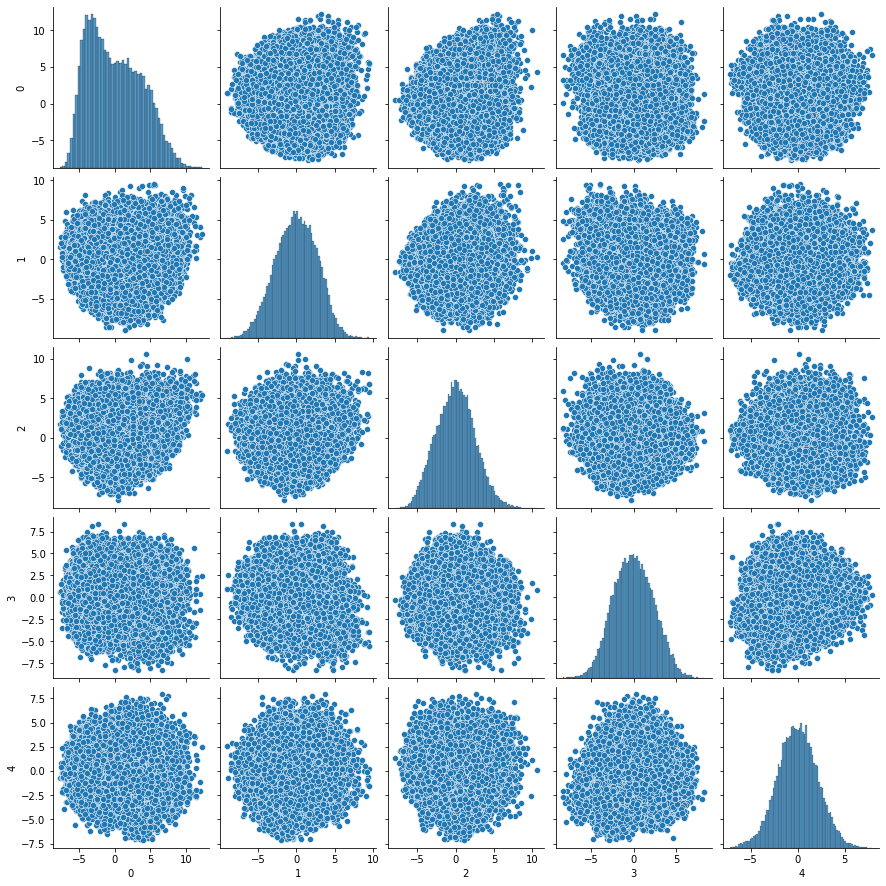

In [11]:
sns.pairplot(pca_data)

In [12]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))

In [13]:
data.loc[data["Authors"] == "Stephen King"]

,Name,Authors,Description
1952,The Shining,Stephen King,Jack Torrance's new job at the Overlook Hotel ...
2372,"The Waste Lands (The Dark Tower, #3)",Stephen King,The Last Gunslinger moves ever closer to the D...
3326,The Dark Half,Stephen King,Thad Beaumont is a Pulitzer Prize-winning auth...
4087,The Dead Zone (Charnwood Library),Stephen King,"Johnny Smith has had a terrible accident, and ..."
5337,"The Green Mile, Part 3: Coffey's Hands",Stephen King,The electric chair is the focus of a chilling ...
6432,Danse macabre,Stephen King,"In the fall of 1978, Stephen King taught at th..."
7037,"Four Past Midnight, Vol. 2",Stephen King,Straight up midnight : an introductory note --...
8027,"The Gunslinger (The Dark Tower, #1)",Stephen King,4 cass. : 6 hr<br />Filled with ominous landsc...
8149,The Talisman,Stephen King,The bestselling collaboration of two masters o...
8401,The Gunslinger,Stephen King,Since the publication of THE GUNSLINGER in an ...


In [23]:
def give_recommendations(index, print_recommendation = False,print_recommendation_plots= False):
  index_recomm =cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]
  books_recomm =  data['Name'].loc[index_recomm].values
  result = {'Books':books_recomm,'Index':index_recomm}
  if print_recommendation==True:
    print('Book Read: %s \n'%(data['Name'].loc[index]))
    k=1
    for book in books_recomm:
      print('Recommended book #%i : %s \n'%(k, book))
      k = k+1
  if print_recommendation_plots==True:
    print('Book Read - Description:\n %s \n'%(data['Description'].loc[index]))
    k=1
    for q in range(len(books_recomm)):
      plot_q = data['Description'].loc[index_recomm[q]]
      print('Recommended Book #%i - Description:\n %s \n'%(k,plot_q))
      k=k+1
  return result

In [24]:
give_recommendations(10580, True, True)

Book Read: It 

Recommended book #1 : Take these Broken Wings 

Recommended book #2 : The Shining 

Recommended book #3 : The Wind Off the Sea (The Bexham Trilogy #2) 

Recommended book #4 : The Invisible Wall 

Recommended book #5 : The Knife of Never Letting Go (Chaos Walking, #1) 

Book Read - Description:
 To the children, the town was their whole world. To the adults, knowing better, Derry, Maine was just their home town: familiar, well-ordered for the most part. A good place to live.<br /><br />It was the children who saw - and felt - what made Derry so horribly different. In the storm drains, in the sewers, IT lurked, taking on the shape of every nightmare, each one's deepest dread. Sometimes IT reached up, seizing, tearing, killing...<br /><br />The adults, knowing better, knew nothing.<br /><br />Time passed and the children grew up, moved away. The horror of IT was deep-buried, wrapped in forgetfulness. Until they were called back, once more to confront IT as it stirred and c

{'Books': array(['Take these Broken Wings', 'The Shining',
        'The Wind Off the Sea (The Bexham Trilogy #2)',
        'The Invisible Wall',
        'The Knife of Never Letting Go (Chaos Walking, #1)'], dtype=object),
 'Index': [22887, 1952, 948, 28447, 31252]}

In [16]:
recomm_list = []
for i in range(len(X)):
  recomm_i = give_recommendations(i)
  recomm_list.append(recomm_i['Books'])
recomm_data = pd.DataFrame(recomm_list,columns=['First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation'])
recomm_data['Books Read'] = data['Name']
recomm_data = recomm_data[['Books Read','First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation']]

In [17]:
recomm_data.sample(frac=1).head()

,Read Books,First Recommendation,Second Recommendation,Third Recommendation,Fourth Recommendation,Fifth Recommendation
7765,"Invisible Privilege: A Memoir About Race, Clas...",Black on the Block: The Politics of Race and C...,Emma Goldman: American Individualist (Library ...,Reena Spaulings,Eagle Song,Woman's Cry
18980,Songs of Papa's Island,The Visit,Just Grandma and Me (A Golden Look-Look Book),The Sand Lady: An Ocean City Maryland Tale,One White Wishing Stone: A Beach Day Counting ...,Old MacDonald Hawaiian Style! Auntie Lulu's Zoo
380,Paul Jennings' Funniest Stories,The Complete Dick Tracy Volume 4: 1936-1938,Dystopia,Legal Briefs: Short Stories by Today's Best Th...,MASTER OF THE PULPS: The Collected Essays of N...,The Annotated Alice: Alice's Adventures In Won...
15231,A French Affair,"The Narrowboat Girl (Narrowboat Girl, #1)","The Loveday Honour (Loveday, #5)",That Summer Affair,"Kissed by the Devil (Kissed by the Devil, #1)",No Time to Say Goodbye: Surviving the Suicide ...
32250,The Wind in the Willows,The Wind in the Willows,"Woman Of The River: Georgie White Clark, White...","The Time Garden (Tales of Magic, #4)",Wildwood Dancing,"Wildwood Dancing (Wildwood, #1)"
